In [15]:
%load_ext autoreload
%autoreload 2

# face extractor

In [15]:
import torch
import numpy as np
import random
torch.manual_seed(23336666)
np.random.seed(23336666)
random.seed(23336666)

kaggle = False
if kaggle:
    !pip install ../input/facenet-pytorch-vggface2/facenet_pytorch-2.0.1-py3-none-any.whl
    !pip install ../input/dfdc-model/codes/pkgs/efficientnet_pytorch-0.6.1/efficientnet_pytorch-0.6.1

import sys, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
import time
import time
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from torchvision.transforms import Normalize, RandomHorizontalFlip, ToTensor, ToPILImage, Compose, Resize
from sklearn.metrics import log_loss
import pathlib
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from hashlib import sha1

if kaggle:
    sys.path += ["/kaggle/input/dfdc-model/codes/pkgs", "/kaggle/input/dfdc-model/codes/utils"]
    blaze_weight = "/kaggle/input/dfdc-model/codes/pkgs/blazeface.pth"
    anchors = "/kaggle/input/dfdc-model/codes/pkgs/anchors.npy"
    from engine import FaceInferenceModel, BlazeFace_extractor, FastDataset, MTCNN_extractor
else:
    blaze_weight = "pkgs/blazeface.pth"
    anchors = "pkgs/anchors.npy"
    from utils.engine import FaceInferenceModel, BlazeFace_extractor, FastDataset, show, Cache_loader, MTCNN_extractor

In [8]:
class Model1(FaceInferenceModel):
    def __init__(self, model_path = "/home/kailu/best_model.pth"):
        super().__init__()
        checkpoint = torch.load(model_path, map_location=device)
        self.model = checkpoint['model']
        self.model.eval()
        
    def _tta(self, pil_img):
        assert pil_img.size == (224, 224)
        return [pil_img]
    
    def predict_batch(self, batch):
        with torch.no_grad():
            batch = batch.to(device)
            y_pred = torch.sigmoid(self.model(batch))
            y = y_pred.detach().cpu().squeeze().numpy()
            return y.reshape(-1)
    
class Model1x(Model1):
    def predict_batch(self, batch):
        with torch.no_grad():
            batch = batch.to(device)
            y_pred = torch.sigmoid(self.model(batch))
            y = y_pred.detach().cpu().squeeze().numpy().reshape(-1)
        y[y<0.5]=0.5
        return y

In [28]:
import albumentations as aug
from numpy.random import choice
trans = [aug.Downscale(0.5, 0.5, p=1), aug.JpegCompression(quality_lower=20, quality_upper=20, p=1), aug.Flip(p=0)]

def augment(imgs, do_augment=True):
    if np.random.randint(3) < 2 and not kaggle and do_augment:
        tran = choice(trans)
        imgs = np.array([tran(**{"image":img})["image"] for img in imgs])
    return imgs

def predict_on_all(video_paths, face_extractor, models, sample_number = 13, use_cache = False, progress_bar = True, do_augment=True):
    if not use_cache:
        ds = FastDataset(video_paths, sample_rate = sample_number)
        loader = DataLoader(ds, batch_size=1, num_workers=10, drop_last=False, shuffle=False)
    else:
        loader = Cache_loader(video_paths)
    
    predicts = []
    if progress_bar:
        loader = tqdm(loader, position=0, leave=True)
    for batch in loader:
        samples = sample_number
        if not use_cache:
            frames = augment(batch[0].data.numpy(), do_augment)
            faces = face_extractor.get_faces(frames, only_one=False)
            faces = [sorted(face, key = lambda x: x.prob)[-1:] for face in faces]
        else:
            faces = [[face] for face in augment(frames, do_augment)]
            
        if len(faces) == 0 or faces is None:
            predicts.append(0.5)
            continue
        np.random.shuffle(faces)
        faces = faces[:samples]
        
        answers = [model.solve_faces(faces) for model in models]
        predicts.append(np.mean(answers))
    return predicts

In [13]:
model_name = "3d12410b_40_49.pth"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
speed_test = True
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using {device}")

if kaggle:
    filenames = glob.glob('/kaggle/input/deepfake-detection-challenge/test_videos/*.mp4')
    models = [Model1("/kaggle/input/dfdc-model/"+model_name)]
else:
    filenames = glob.glob('/home/lthpc/test_videos/*.mp4')
    models = [Model1("/home/kailu/"+model_name)]

filenames = sorted(filenames)
face_extractor = MTCNN_extractor(factor=0.5)

using cuda:0


In [21]:
if speed_test:
    testnum = 10
    start = time.time()
    ret = predict_on_all(filenames[:testnum], models=models, face_extractor=face_extractor)
    time_dur = time.time()-start
    print(f"totally {time_dur} s used, {time_dur/testnum} s per video, mean = {np.mean(ret)}")

100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

totally 2.5623879432678223 s used, 2.5623879432678223 s per video, mean = 0.44632433354854584


  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

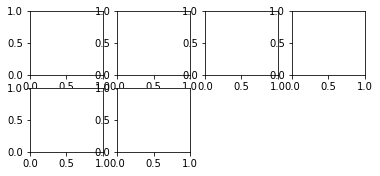

In [115]:
predictions = predict_on_all(filenames, models=models, face_extractor=face_extractor, do_augment=False)
print(np.mean(predictions))
submission_df = pd.DataFrame({"filename": [fn.split('/')[-1] for fn in filenames], "label": predictions})
# submission_df.to_csv("submission.csv", index=False)
# 0.4284

# Extra Code to limit memory usage

In [ ]:
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_AS)
resource.setrlimit(resource.RLIMIT_AS, (16000000000, hard))

In [ ]:
if True:
    # extreme case tests for face_extractor
    frames = np.array([cv2.cvtColor(cv2.imread("pkgs/extreme.jpeg"), cv2.COLOR_BGR2RGB)]*10)
    ret= face_extractor.get_faces(frames, only_one=False)
    print(len(ret), len(ret[0]))

# Claculate Acc for 0/1 output

In [8]:
score = 8.13392
penalty = 17.26938*2
acc = 1 - score/penalty
acc

0.7644987833958139

In [9]:
best_x = 1-acc

# Face alinement

In [23]:
blaze = BlazeFace_extractor(blaze_weight, anchors, scale=1.15)
mtcnn = MTCNN_extractor()
frames = FastDataset(filenames, sample_rate = 15)[0]

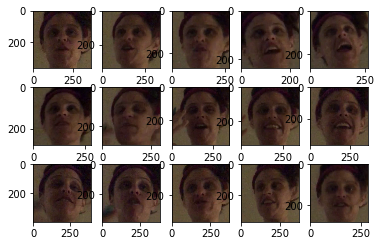

In [12]:
show(mtcnn.get_faces(frames))

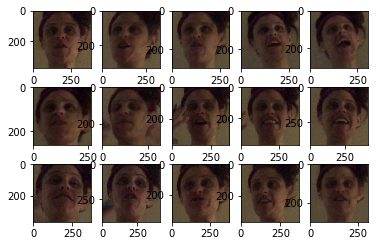

In [24]:
show(blaze.get_faces(frames))

In [15]:
%load_ext autoreload
%autoreload 2
# %debug

# refine validation

In [520]:
info_t = infox[infox["label"]==1]["loss"]
metadata.loc[info_t[info_t<0.3].index,"split_kailu"]=-1

print(len(metadata[(metadata["split_kailu"].isin(["validation", "test"]))]))

ori = set(metadata[(metadata["split_kailu"].isin(["validation", "test"])) & (metadata["label"]=="FAKE")]["original"])
reals = metadata[(metadata["split_kailu"].isin(["validation", "test"])) & (metadata["label"]=="REAL")].index
drops = [fn for fn in reals if fn not in ori]
# metadata.loc[drops,"split_kailu"]=-1

print(len(metadata[(metadata["split_kailu"].isin(["validation", "test"]))]))

# metadata.T.to_json(f'/data/deepfake/metadata/metadata_40_49_dropped.json')

21334
21334


In [524]:
def get_split(row):
    if row.label == 'REAL':
        return metadata.loc[row.name,'split_kailu']
    else:
        return metadata.loc[row.original,'split_kailu']
    
# metadata["split_kailu"] = metadata.apply(get_split, 1)
print(len(metadata[(metadata["split_kailu"].isin(["validation", "test"]))]))
metadata.T.to_json(f'/data/deepfake/metadata/metadata_40_49_newdrop.json')

5492


In [528]:
len(info_t)

4328

In [518]:

len(info_t), len(info_t[info_t<0.25]), info_t[info_t>0.25].mean()

(4328, 3315, 0.6978240476838294)

In [519]:
info_t[info_t<0.25].index

Index(['qelncdmypn.mp4', 'bghpxawcnb.mp4', 'biefjlethf.mp4', 'awvnopdojm.mp4',
       'erdciikvep.mp4', 'kqedczfnqm.mp4', 'ysabcaidhs.mp4', 'caikegrhfs.mp4',
       'xdxpdhcqdf.mp4', 'fxfxtrrkeq.mp4',
       ...
       'hshapbcail.mp4', 'zunuthfegz.mp4', 'kgyowtaqzn.mp4', 'iarkkhmyta.mp4',
       'njyowkvohi.mp4', 'cfqmnjcuwa.mp4', 'pwglpxzofe.mp4', 'zpgqjxivpx.mp4',
       'buywrbgfqy.mp4', 'bevjclbhuo.mp4'],
      dtype='object', name='file', length=3315)

In [259]:
drops = ret[(ret<0.23)].index
info2 = info.drop(info[info["class"].isin(drops)].index) 
print(len(info), len(info2), calc(info2))

4000 3933 0.5686165340159682


In [260]:
metadata.loc[metadata['class'].isin(drops),"split_kailu"]=-1
metadata.T.to_json(f'/data/deepfake/metadata/metadata_half_dropped.json')

In [204]:
def show_faces(file_list, title = None):
    from settings import face_cache_path
    import matplotlib.pyplot as plt
    
    if '/' in file_list[0]:
        file_list = [fn.split("/")[-1] for fn in file_list]
    if '.' in file_list[0]:
        file_list = [fn.split(".")[0] for fn in file_list]
    if title is None:
        title = file_list
    
    nlen = len(file_list)
    colums = max(5, int(np.sqrt(nlen))//2)
    rows = (nlen+colums-1)//colums
    fig, axes = plt.subplots(rows , colums, figsize=(15, rows*(15/colums*1.2)))
    axes = np.array(axes)
    axes = axes.reshape(-1)

    ax_ix = 0
    for fn, tt in tqdm(zip(file_list, title)):
        cache_path = os.path.join(face_cache_path, fn)
        files = os.listdir(cache_path)
        with open(os.path.join(cache_path, files[0]), 'rb') as f:
            face = Image.open(f)
            face.load()
            image = np.array(face)
        
        axes[ax_ix].imshow(image)
        axes[ax_ix].xaxis.set_visible(False)
        axes[ax_ix].yaxis.set_visible(False)
        axes[ax_ix].set_title(tt)
        ax_ix += 1

    plt.grid(False)
    plt.show()
    
def view_loss(showdf, key="loss"):
    show_faces(showdf.index, list(showdf[key]))



0it [00:00, ?it/s]

16it [00:00, 157.01it/s]

30it [00:00, 148.88it/s]

42it [00:00, 136.01it/s]

56it [00:00, 135.60it/s]

70it [00:00, 134.56it/s]

71it [00:00, 130.02it/s]

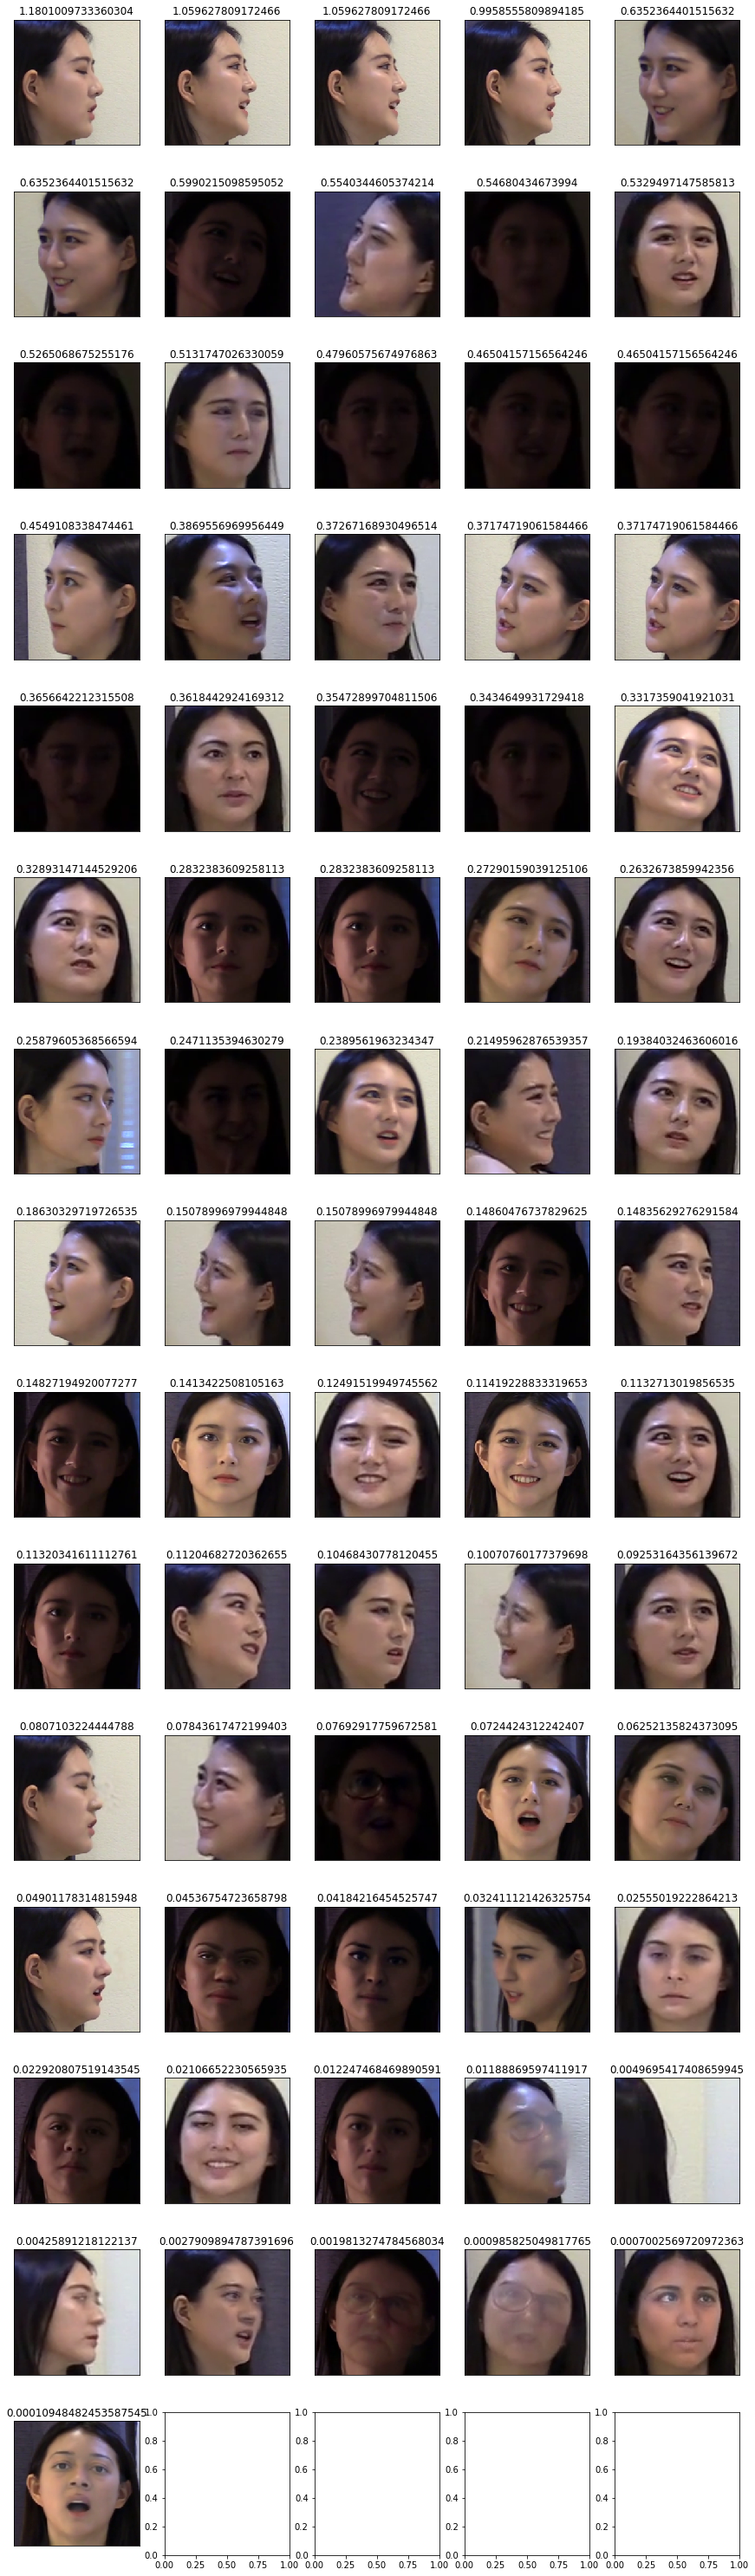

In [252]:
showdf = info[info['class']==20]
show_faces(showdf.index, list(showdf["loss"]))

# Models and Kaggle Score

In [30]:
history = pd.DataFrame([
["best_model_test","MTCNN",0.77206,0.7053863016318175,1.1027377531054388,0.30803485015819476,"half_dropped"],
["best_model_test","MTCNN",0.77206,0.6454147494712076,0.9835658562620353,0.307263642680372,"half"],
['best_model_test','MTCNN',0.77206,0.7092709248637348,0.8872980770489679,0.5312437726784999,'little_drops_augmented'],
['best_model_test','MTCNN',0.77206,0.6508480092902007,0.9921257512554271,0.30957026732497256,'little_drops'],
["best_model_high_drop","MTCNN",0.655,0.4527596782150778,0.6494400193866284,0.25607933704352476,"half_dropped"],
["best_model_high_drop","MTCNN",0.655,0.39953121896785376,0.5685360126108464,0.23052642532486015,"half"],
['best_model_high_drop','MTCNN',0.655,0.4013999549158951,0.562338374289174,0.240461535542618,'little_drops'],
["best_model_high_drop","MTCNN,reset 0.5-0.9",0.670,0.44294882089329607,0.5046417460438122,0.3812558957427985,"half_dropped"],
['best_model_high_drop','MTCNN',0.655,0.6934798011976696,0.7101204902721845,0.6768391121231556,'little_drops_augmented'],
["best_model_dropped","Blazeface",0.914,0.5801113992711593,1.0294010686124824,0.13082172992983424,"half_dropped"],
["best_model_dropped","MTCNN",0.798,0.5801113992711593,1.0294010686124824,0.13082172992983424,"half_dropped"],
['best_model_dropped','MTCNN',0.798,0.5164834163745055,0.909880770445527,0.1230860623034832,'little_drops'],
["best_model_dropped","MTCNN",0.798,0.4964839010223049,0.8784946300337698,0.11447317201084176,"half"],
['best_model_dropped','MTCNN',0.798,0.6416224923676249,0.8633961475709206,0.4198488371643267,'little_drops_augmented'],
["61329d4a_freeze","MTCNN",0.70692,0.3274738692106253,0.3984578645338978,0.25648987388735,"half_dropped"],
["61329d4a_freeze","MTCNN",0.70692,0.298915309381837,0.3442754221303321,0.25355519663334225,"half"],
['61329d4a_freeze','MTCNN',0.70692,0.29861315915522635,0.33885604147104564,0.25837027683940655,'little_drops'],
['61329d4a_freeze','MTCNN',0.70692,0.7600134156866614,1.1938455015556944,0.3261813298176293,'little_drops_augmented'],
["070c63f6_freeze","MTCNN",0.508,0.3703480335052523,0.541174552052407,0.19952151495809864,"half_dropped"],
["070c63f6_freeze","MTCNN",0.508,0.3445346882134333,0.4801632288555545,0.2089061475713127,"half"],
['070c63f6_freeze','MTCNN',0.508,0.6222508426507344,0.7624280422707155,0.4820736430307534,'little_drops_augmented'],
['070c63f6_freeze','MTCNN',0.508,0.34391023808093124,0.47876051495194843,0.20905996120991346,'little_drops'],
['070c63f6_freeze','MTCNN',0.508,0.47653193120097875,0.5834445248910108,0.36961933751094583,'metadata_half_dropped_augmented' ],
['61329d4a_freeze','MTCNN',0.70692,0.4586712762914841,0.376282966746941,0.5410595858360253,'metadata_half_dropped_augmented' ],
['best_model_dropped','MTCNN',0.798,0.6014468865570776,0.7937460596385104,0.4091477134756425,'metadata_half_dropped_augmented' ],
['best_model_high_drop','MTCNN',0.655,0.5837091783742199,0.49368838433370604,0.6737299724147349,'metadata_half_dropped_augmented' ],
['best_model_test','MTCNN',0.77206,0.6992430919367457,0.8965005971115372,0.5019855867619536,'metadata_half_dropped_augmented' ],
['4f16c363_40_49','MTCNN',0.48596,0.5911676357327079,0.6523130587428011,0.5300222127226139,'metadata_40_49_dropped_augmented' ],
['b4ba3cd3_40_49','MTCNN',0.56812,0.6784479647473978,0.8157165055993195,0.5411794238954745,'metadata_40_49_dropped_augmented' ],
['4f16c363_40_49','MTCNN set <0.5 to 0.5',0.58805,0.6326034440762619,0.8235676833645965,0.4416392047879256,'metadata_40_49_dropped_augmented' ],
['09cd81f8_40_49','MTCNN',0.53915,0.659564744135743,0.535803840432763,0.7833256478387213,'metadata_40_49_dropped_augmented' ],
['3d12410b_40_49','MTCNN',0.45246,0.5773311429611593,0.4770153597445252,0.677646926177793,'metadata_40_49_dropped_augmented' ],
['a64e6fb7_40_49','MTCNN',0,0.5656914917433298,0.6158004292579647,0.5155825542286948,'metadata_40_49_dropped_augmented' ],
['meta_40_49_overfit','MTCNN',0.76381,0.7380860384404151,0.44123297134889805,1.0349391055319324,'metadata_40_49_dropped_augmented' ],
['3d12410b_40_49_bug_fixed_multiface','MTCNN',0.40505,0.4507418742313733,0.3710848590249063,0.5303988894378406,'metadata_40_49_dropped_augmented'],
['3d12410b_40_49_bug_fixed_singleface','MTCNN',0,0.4684917176429772,0.31153847660270967,0.6254449586832455,'metadata_40_49_dropped_augmented' ],    
['3d12410b_40_49_bug_fixed_singleface_old_infer','MTCNN',0.39802,0,0,0,'metadata_40_49_dropped_augmented'],
], columns=["pth", "extractor", "kaggle score", "val", "val on real", "val on fake", "split used"])
history

pth              extractor  \
0                                 best_model_test                  MTCNN   
1                                 best_model_test                  MTCNN   
2                                 best_model_test                  MTCNN   
3                                 best_model_test                  MTCNN   
4                            best_model_high_drop                  MTCNN   
5                            best_model_high_drop                  MTCNN   
6                            best_model_high_drop                  MTCNN   
7                            best_model_high_drop    MTCNN,reset 0.5-0.9   
8                            best_model_high_drop                  MTCNN   
9                              best_model_dropped              Blazeface   
10                             best_model_dropped                  MTCNN   
11                             best_model_dropped                  MTCNN   
12                             best_model_dropped                  MTCNN   
13                             best_model_dropped                  MTCNN   
14                                61329d4a_freeze                  MTCNN   
15                                61329d4a_freeze                  MTCNN   
16                                61329d4a_freeze                  MTCNN   
17                                61329d4a_freeze                  MTCNN   
18                                070c63f6_freeze                  MTCNN   
19                                070c63f6_freeze                  MTCNN   
20                                070c63f6_freeze                  MTCNN   
21                                070c63f6_freeze                  MTCNN   
22                                070c63f6_freeze                  MTCNN   
23                                61329d4a_freeze                  MTCNN   
24                             best_model_dropped                  MTCNN   
25                           best_model_high_drop                  MTCNN   
26                                best_model_test                  MTCNN   
27                                 4f16c363_40_49                  MTCNN   
28                                 b4ba3cd3_40_49                  MTCNN   
29                                 4f16c363_40_49  MTCNN set <0.5 to 0.5   
30                                 09cd81f8_40_49                  MTCNN   
31                                 3d12410b_40_49                  MTCNN   
32                                 a64e6fb7_40_49                  MTCNN   
33                             meta_40_49_overfit                  MTCNN   
34             3d12410b_40_49_bug_fixed_multiface                  MTCNN   
35            3d12410b_40_49_bug_fixed_singleface                  MTCNN   
36  3d12410b_40_49_bug_fixed_singleface_old_infer                  MTCNN   

    kaggle score       val  val on real  val on fake  \
0        0.77206  0.705386     1.102738     0.308035   
1        0.77206  0.645415     0.983566     0.307264   
2        0.77206  0.709271     0.887298     0.531244   
3        0.77206  0.650848     0.992126     0.309570   
4        0.65500  0.452760     0.649440     0.256079   
5        0.65500  0.399531     0.568536     0.230526   
6        0.65500  0.401400     0.562338     0.240462   
7        0.67000  0.442949     0.504642     0.381256   
8        0.65500  0.693480     0.710120     0.676839   
9        0.91400  0.580111     1.029401     0.130822   
10       0.79800  0.580111     1.029401     0.130822   
11       0.79800  0.516483     0.909881     0.123086   
12       0.79800  0.496484     0.878495     0.114473   
13       0.79800  0.641622     0.863396     0.419849   
14       0.70692  0.327474     0.398458     0.256490   
15       0.70692  0.298915     0.344275     0.253555   
16       0.70692  0.298613     0.338856     0.258370   
17       0.70692  0.760013     1.193846     0.326181   
18       0.50800  0.370348     0.541175     0.199522   
19       0.50800  0.344535     0.4801

In [28]:
history[history["split used"]=="metadata_40_49_dropped_augmented"]

pth              extractor  kaggle score       val  \
27      4f16c363_40_49                  MTCNN       0.48596  0.591168   
28      b4ba3cd3_40_49                  MTCNN       0.56812  0.678448   
29      4f16c363_40_49  MTCNN set <0.5 to 0.5       0.58805  0.632603   
30      09cd81f8_40_49                  MTCNN       0.53915  0.659565   
31      3d12410b_40_49                  MTCNN       0.45246  0.577331   
32      a64e6fb7_40_49                  MTCNN       0.00000  0.565691   
33  meta_40_49_overfit                  MTCNN       0.76381  0.738086   

    val on real  val on fake                        split used  
27     0.652313     0.530022  metadata_40_49_dropped_augmented  
28     0.815717     0.541179  metadata_40_49_dropped_augmented  
29     0.823568     0.441639  metadata_40_49_dropped_augmented  
30     0.535804     0.783326  metadata_40_49_dropped_augmented  
31     0.477015     0.677647  metadata_40_49_dropped_augmented  
32     0.615800     0.515583  metadata_40_49_dropped_augmented  
33     0.441233     1.034939  metadata_40_49_dropped_augmented

In [29]:
history[history["split used"]=="little_drops"]

pth extractor  kaggle score       val  val on real  \
3        best_model_test     MTCNN       0.77206  0.650848     0.992126   
6   best_model_high_drop     MTCNN       0.65500  0.401400     0.562338   
11    best_model_dropped     MTCNN       0.79800  0.516483     0.909881   
16       61329d4a_freeze     MTCNN       0.70692  0.298613     0.338856   
21       070c63f6_freeze     MTCNN       0.50800  0.343910     0.478761   

    val on fake    split used  
3      0.309570  little_drops  
6      0.240462  little_drops  
11     0.123086  little_drops  
16     0.258370  little_drops  
21     0.209060  little_drops

In [30]:
history[history["split used"]=="metadata_half_dropped_augmented"]

pth extractor  kaggle score       val  val on real  \
22       070c63f6_freeze     MTCNN       0.50800  0.476532     0.583445   
23       61329d4a_freeze     MTCNN       0.70692  0.458671     0.376283   
24    best_model_dropped     MTCNN       0.79800  0.601447     0.793746   
25  best_model_high_drop     MTCNN       0.65500  0.583709     0.493688   
26       best_model_test     MTCNN       0.77206  0.699243     0.896501   

    val on fake                       split used  
22     0.369619  metadata_half_dropped_augmented  
23     0.541060  metadata_half_dropped_augmented  
24     0.409148  metadata_half_dropped_augmented  
25     0.673730  metadata_half_dropped_augmented  
26     0.501986  metadata_half_dropped_augmented

In [22]:
from sklearn.metrics import roc_auc_score

def gen_data(datadf):
    return  ["/data1/data/deepfake/dfdc_train/" + fn for fn in datadf.index], [0 if la=='REAL' else 1 for la in datadf.label]

def get_info(model_path, test_df, Model, use_cache):
    name = model_path.split("/")[-1].split(".")[0]
    filenames, labels = gen_data(test_df)
    models = [Model(model_path)]
    face_extractor = MTCNN_extractor(factor=0.5)
    predictions = predict_on_all(filenames, models=models, face_extractor=face_extractor, sample_number=13, use_cache=use_cache) # 
    
    info = pd.DataFrame({"file": [fn.split("/")[-1] for fn in filenames], "label": labels, "predict": predictions}).set_index("file")
    try:
        info['class'] = df['class']
    except:
        pass
    info["loss"] = info.apply(lambda row: log_loss([row.label], [row.predict], labels=[0,1]), axis=1)
    info.sort_values("loss", inplace=True, ascending=False)
    return info

def fast_report(model_path, test_df, kaggle_score = np.nan, split_name = "unset", Model = Model1, augment = True, use_cache = False):
    np.random.seed(23336666)
    global trans
    if augment:
        trans = [aug.Downscale(0.5, 0.5, p=1), aug.JpegCompression(quality_lower=20, quality_upper=20, p=1), aug.Flip(p=0)]
        suffix = "_augmented"
    else:
        trans = [aug.Flip(p=0)]
        suffix = ""
    
    name = model_path.split("/")[-1].split(".")[0]
    info = get_info(model_path, test_df, Model, use_cache=use_cache)
    loss = info["loss"].mean()
    loss_real = info[info["label"]==0]["loss"].mean()
    loss_fake = info[info["label"]==1]["loss"].mean()
    roc = roc_auc_score(info["label"], info["predict"])
    
    print(f"['{name}','MTCNN',{kaggle_score},{loss},{loss_real},{loss_fake},'{split_name}{suffix}' ],")
    return info

In [24]:
def accurate_sample(df, number = 400):
    reals = df[df["label"] == "REAL"].sample(number)
    fakes = pd.concat([df[df["original"]==name].sample(1) for name in reals.index])
    return pd.concat([reals, fakes])

In [25]:
split_name = "metadata_40_49_dropped"
metadata = pd.read_json(f'/data/deepfake/metadata/{split_name}.json').T
df = metadata[((metadata['split_kailu'] == 'validation'))] # | (metadata['split_kailu'] == 'test')
df = accurate_sample(df)

In [31]:
# info1 = fast_report("/home/kailu/070c63f6_freeze.pth" ,df, kaggle_score=0.508, split_name=split_name)
# info2 = fast_report("/home/kailu/61329d4a_freeze.pth" ,df, kaggle_score=0.70692, split_name=split_name)
# info3 = fast_report("/home/kailu/best_model_dropped.pth" ,df, kaggle_score=0.798, split_name=split_name)
# info4 = fast_report("/home/kailu/best_model_high_drop.pth" ,df, kaggle_score=0.655, split_name=split_name)
# info5 = fast_report("/home/kailu/best_model_test.pth" ,df, kaggle_score=0.77206, split_name=split_name)

# info6 = fast_report("/home/kailu/4f16c363_40_49.pth" ,df, kaggle_score=0.48596, split_name=split_name)
# info6 = fast_report("/home/kailu/b4ba3cd3_40_49.pth" ,df, kaggle_score=0.56812, split_name=split_name)
# info6 = fast_report("/home/kailu/4f16c363_40_49.pth" ,df, kaggle_score=0.58805, split_name=split_name, Model=Model1x) # set <0.5 to 0.5
# info7 = fast_report("/home/kailu/09cd81f8_40_49.pth" ,df, kaggle_score=0.53915, split_name=split_name)
# info8 = fast_report("/home/kailu/3d12410b_40_49.pth" ,df, kaggle_score=0.45246, split_name=split_name) # loss = 0.5773311429611594
# info9 = fast_report("/home/kailu/a64e6fb7_40_49.pth" ,df, kaggle_score=0, split_name=split_name)
# info10 = fast_report("/home/kailu/a0de196a_40_49.pth" ,df, kaggle_score=0, split_name=split_name)
info11 = fast_report("/home/kailu/cf0c4be3_40_49.pth" ,df, kaggle_score=0, split_name=split_name)

# infox = fast_report("/home/kailu/meta_40_49_overfit.pth" ,df, kaggle_score=0.76381, split_name=split_name)

# info7 = fast_report("/home/kailu/09cd81f8_40_49.pth" ,df, kaggle_score=0.53915, split_name=split_name, augment=False, use_cache=True)
# infox = fast_report("/home/kailu/meta_40_49_overfit.pth" ,df, kaggle_score=0.76381, split_name=split_name)
# infoy = fast_report("/home/kailu/4f16c363_40_49.pth" ,df, kaggle_score=0.48596, split_name=split_name, augment=False, use_cache=True)

100%|██████████| 800/800 [06:29<00:00,  2.05it/s]


['cf0c4be3_40_49','MTCNN',0,0.4914932255245391,0.37656797816083265,0.6064184728882432,'metadata_40_49_dropped_augmented' ],


In [409]:
scale_list = [0.5]
jpeg_list = [5, 8, 10, 15]
p_list = [0.3, 0.5, 0.7, 1]
results = {}
for scale in scale_list:
    for jpeg in jpeg_list:
        for p in p_list:
            trans = [aug.Downscale(scale, scale, p=p), aug.JpegCompression(quality_lower=jpeg, quality_upper=jpeg, p=p), aug.Flip(p=0)]
            info1 = fast_report("/home/kailu/070c63f6_freeze.pth" ,df, kaggle_score=0.508, split_name=split_name)
            info2 = fast_report("/home/kailu/61329d4a_freeze.pth" ,df, kaggle_score=0.70692, split_name=split_name)
            info3 = fast_report("/home/kailu/best_model_dropped.pth" ,df, kaggle_score=0.798, split_name=split_name)
            if info1["loss"].mean() < info2["loss"].mean() < info3["loss"].mean():
                results[(scale, jpeg, p)] = (info1, info2, info3)
print(results)
trans = [aug.Downscale(0.5, 0.5, p=1), aug.JpegCompression(quality_lower=20, quality_upper=20, p=1), aug.Flip(p=0)]

100%|██████████| 800/800 [10:52<00:00,  1.37it/s]


loss = 0.3749326228198197
['070c63f6_freeze','MTCNN',0.508,0.3749326228198197,0.4861270320684112,0.2637382135712285,0.92050625,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [10:31<00:00,  1.41it/s]


loss = 0.3106323724719123


  0%|          | 0/800 [00:00<?, ?it/s]

['61329d4a_freeze','MTCNN',0.70692,0.31063237247191205,0.3066915721130067,0.3145731728308181,0.94295,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [10:15<00:00,  1.38it/s]


loss = 0.48864032180252176


  0%|          | 0/800 [00:00<?, ?it/s]

['best_model_dropped','MTCNN',0.798,0.48864032180252104,0.7999609224620597,0.1773197211429822,0.8947375,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [10:46<00:00,  1.18it/s]


loss = 0.389883745915746
['070c63f6_freeze','MTCNN',0.508,0.3898837459157463,0.4976580322924243,0.28210945953906724,0.9126749999999999,'metadata_half_little_drops_augmented' ],


 54%|█████▍    | 435/800 [06:04<04:33,  1.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 800/800 [10:46<00:00,  1.36it/s]


loss = 0.38203955230852643
['070c63f6_freeze','MTCNN',0.508,0.3820395523085264,0.48690804843887947,0.2771710561781732,0.9157624999999999,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [10:58<00:00,  1.26it/s]


loss = 0.3172381330755756
['61329d4a_freeze','MTCNN',0.70692,0.31723813307557536,0.2933205893546685,0.3411556767964825,0.940075,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [10:47<00:00,  1.37it/s]


loss = 0.47880416098788103


  0%|          | 0/800 [00:00<?, ?it/s]

['best_model_dropped','MTCNN',0.798,0.47880416098788076,0.7651718315334766,0.19243649044228575,0.89325,'metadata_half_little_drops_augmented' ],


100%|█████████▉| 799/800 [11:40<00:00,  1.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 800/800 [10:54<00:00,  1.28it/s]


loss = 0.4690184866826438


  0%|          | 0/800 [00:00<?, ?it/s]

['best_model_dropped','MTCNN',0.798,0.4690184866826444,0.7472685429074083,0.19076843045787925,0.8998125,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [11:32<00:00,  1.31it/s]


loss = 0.3991420473006345
['070c63f6_freeze','MTCNN',0.508,0.3991420473006347,0.500168229148884,0.2981158654523855,0.9049750000000001,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [11:26<00:00,  1.10it/s]


loss = 0.3273321924893516


  0%|          | 0/800 [00:00<?, ?it/s]

['61329d4a_freeze','MTCNN',0.70692,0.32733219248935114,0.2873686118135453,0.36729577316515793,0.933375,'metadata_half_little_drops_augmented' ],


100%|██████████| 800/800 [11:34<00:00,  1.02it/s]


loss = 0.4530729670255242
['best_model_dropped','MTCNN',0.798,0.45307296702552463,0.688052108430631,0.2180938256204174,0.8976749999999999,'metadata_half_little_drops_augmented' ],


 19%|█▉        | 152/800 [02:20<08:27,  1.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [410]:
for key, val in results.items():
    info1, info2, info3 = val
    print(key, info1["loss"].mean() , info2["loss"].mean() , info3["loss"].mean())

In [327]:
diff = info2.copy()
diff["loss1"] = info1["loss"]
diff["loss2"] = info2["loss"]
diff["loss3"] = info3["loss"]
diff["loss4"] = info4["loss"]
diff["loss5"] = info5["loss"]
diff["diff"] = info2["loss"]-info3["loss"]
# diff["diff"] = (info1["loss"]-0.71).abs()+(info2["loss"]-0.51).abs()+(info3["loss"]-0.8).abs()+(info4["loss"]-0.66).abs()+(info5["loss"]-0.77).abs()
diff.sort_values("diff", inplace=True, ascending=False)
diff

label   predict class      loss     loss1     loss2     loss3  \
file                                                                            
hbcasaspdr.mp4      0  0.999237     2  7.178469  2.047830  7.178469  1.483326   
sfdlhkypix.mp4      0  0.961862    10  3.266556  0.640198  3.266556  0.501076   
maqgedtnrq.mp4      0  0.958473    10  3.181415  1.198685  3.181415  0.597144   
vhkxxdxgcn.mp4      0  0.948693   166  2.969936  0.849164  2.969936  0.650764   
ioatsvnnur.mp4      0  0.958343     0  3.178277  1.099366  3.178277  0.943448   
ptxcpwhcwg.mp4      1  0.075915    12  2.578147  0.007667  2.578147  0.449866   
djmwdamqbh.mp4      1  0.099314    83  2.309466  0.344046  2.309466  0.229266   
pilaglcgpu.mp4      0  0.921305    12  2.542170  0.648872  2.542170  0.548697   
ngywzsneek.mp4      0  0.998103    35  6.267721  3.398667  6.267721  4.384643   
ldyuqndngl.mp4      0  0.893979    10  2.244118  1.476221  2.244118  0.367508   
sklzeozsfm.mp4      1  0.143315   138  1.942713  0.002438  1.942713  0.074249   
hobqnnblkq.mp4      1  0.112123    10  2.188161  0.102882  2.188161  0.374377   
pyhhvpyngr.mp4      1  0.191835    10  1.651117  0.001359  1.651117  0.015078   
ewpkflkuah.mp4      0  0.853348    10  1.919690  0.216294  1.919690  0.316695   
uodarndzsb.mp4      0  0.858214    10  1.953434  0.736528  1.953434  0.467812   
dnvtqaalwe.mp4      0  0.875146    10  2.080608  1.310155  2.080608  0.603545   
ekrxyzlqgm.mp4      0  0.881412    10  2.132102  3.158163  2.132102  0.660587   
mkkdnbvows.mp4      1  0.113275    12  2.177933  0.025060  2.177933  0.711170   
dbjmhpklbv.mp4      0  0.877339    10  2.098329  0.986328  2.098329  0.643682   
jvuwsnvypv.mp4      0  0.766575    10  1.454896  0.116985  1.454896  0.097879   
xxnoxvcpxz.mp4      0  0.748131    10  1.378846  0.083310  1.378846  0.038557   
knofhbbqbp.mp4      1  0.275568    32  1.288922  0.214650  1.288922  0.000336   
xgelqxcxdy.mp4      1  0.146106    10  1.923423  0.379906  1.923423  0.742586   
aumnwnognw.mp4      1  0.277841    20  1.280707  0.042146  1.280707  0.144852   
lvyfgfceys.mp4      1  0.219077    10  1.518332  0.026054  1.518332  0.481729   
xzgvdrtnek.mp4      0  0.770446    10  1.471616  0.105550  1.471616  0.463501   
abepvlivgr.mp4      0  0.857997    10  1.951910  1.293117  1.951910  0.949572   
fcgsaskflq.mp4      0  0.757126    10  1.415211  0.958282  1.415211  0.459736   
xhtnxeqjhp.mp4      1  0.359522    10  1.022979  0.895371  1.022979  0.067773   
ydiwlrowzh.mp4      1  0.362167    14  1.015649  0.003355  1.015649  0.126092   
...               ...       ...   ...       ...       ...       ...       ...   
ycptyqmohe.mp4      0  0.473767    82  0.642012  3.005362  0.642012  1.803518   
woqoadphrq.mp4      1  0.946893    95  0.054570  0.363514  0.054570  1.246530   
ifdycojmja.mp4      0  0.394772    10  0.502150  1.871468  0.502150  1.703133   
whkrlhuqyg.mp4      0  0.488785    10  0.670965  3.415041  0.670965  1.894648   
yuvzsrxurn.mp4      0  0.194809   129  0.216676  3.398868  0.216676  1.527242   
yirhagecsp.mp4      1  0.915488    10  0.088298  0.269992  0.088298  1.411125   
zlbikqiqey.mp4      0  0.502817    10  0.698797  3.124513  0.698797  2.029240   
riqviyxuvz.mp4      1  0.946087    10  0.055421  0.105589  0.055421  1.432695   
fzkjhuifsb.mp4      1  0.534193   181  0.626998  1.344003  0.626998  2.110470   
eskgxjnagp.mp4      0  0.480874    10  0.655609  0.012430  0.655609  2.139601   
jcglqjqhan.mp4      1  0.372673    10  0.987053  1.810459  0.987053  2.553873   
sboiescabo.mp4      1  0.596882    10  0.516036  0.991152  0.516036  2.132921   
cvqyddpcxj.mp4      1  0.435441    10  0.831395  1.556621  0.831395  2.477080   
phcagajawr.mp4      0  0.177264    10  0.195119  2.155192  0.195119  1.873996   
dviudfholf.mp4      1  0.725029    10  0.321544  0.778682  0.321544  2.125182   
gwvwbbfckb.mp4      0  0.306743    10  0.366355  2.353940  0.366355  2.170695   
jgfvckriik.mp4      1  0.246480    10  1.400474

In [492]:
info1["loss"].mean()
# info2["loss"].mean()
# np.corrcoef([info1["loss"], info2["loss"], info3["loss"], info4["loss"], info5["loss"]])
# after_dropped = diff[diff["diff"]<5]
# print(len(after_dropped))
# # 0.71 0.51 0.8 0.66 0.77
# after_dropped["loss1"].mean(), after_dropped["loss2"].mean(), after_dropped["loss3"].mean(), after_dropped["loss4"].mean(), after_dropped["loss5"].mean()

0.35311037495732306

In [456]:
def adjust(info, real_ratio=0.05, fake_ratio=0):
    info = info.copy()
    real_val = 0
    fake_val = 1
    if real_ratio<0:
        real_ratio = - real_ratio
        real_val = 1
    if fake_ratio<0:
        fake_ratio = - fake_ratio
        fake_val = 0
    info.loc[info["label"]==0, "predict"] = info[info["label"]==0]["predict"]*(1-real_ratio) + real_val*real_ratio
    info.loc[info["label"]==1, "predict"] = info[info["label"]==1]["predict"]*(1-fake_ratio) + fake_val*fake_ratio
    return log_loss(info["label"], info["predict"])
    
def test_threhold(real_ratio=0.5, fake_ratio=-0.3):
    print(adjust(info1, real_ratio, fake_ratio))
    print(adjust(info2, real_ratio, fake_ratio))
    print(adjust(info3, real_ratio, fake_ratio))
    print(adjust(info4, real_ratio, fake_ratio))
    print(adjust(info5, real_ratio, fake_ratio))
    
test_threhold()

0.4686809537094146
0.5177665853553558
0.5028432343336778
0.6011589766914013
0.5737319921975808


In [434]:
info2.apply(lambda row: log_loss([row.label], [row.predict*0.95+row.label*0.05], labels=[0,1]), axis=1).mean()

0.40085624955802546

In [281]:
ret = diff.groupby(diff["class"]).mean()
ret[ret["label"]==0.5]

label   predict      loss     loss1     loss2     loss3     loss4  \
class                                                                      
14       0.5  0.732810  0.540682  0.544748  0.540682  0.268113  0.400048   
22       0.5  0.574831  0.194451  0.827940  0.194451  0.388211  0.398171   
40       0.5  0.560853  0.488386  0.542251  0.488386  0.833634  1.078803   
44       0.5  0.340592  0.578135  0.505520  0.578135  0.774217  1.016147   
60       0.5  0.388388  0.307497  2.954223  0.307497  1.446397  1.954710   
92       0.5  0.719209  0.295967  0.294027  0.295967  0.024004  0.339685   
95       0.5  0.464749  1.087861  1.108788  1.087861  0.629322  0.516397   
103      0.5  0.810298  0.705648  2.784639  0.705648  1.736884  1.482235   
108      0.5  0.546647  0.097943  1.157059  0.097943  0.766634  1.222307   
144      0.5  0.506920  0.172284  2.042081  0.172284  1.201126  2.313658   
174      0.5  0.567937  0.074458  1.527175  0.074458  0.256093  0.058901   

          loss5      diff  
class                      
14     0.525304  0.238427  
22     0.620791  0.015542  
40     0.680160 -0.184177  
44     0.677074 -0.104733  
60     1.135385 -0.065415  
92     0.438767  0.282407  
95     0.617088  0.320905  
103    1.836948 -0.317342  
108    0.581463 -0.122821  
144    0.510411 -0.026049  
174    0.477564  0.177655

In [552]:
diff = infox.copy()
diff["lossx"] = infox["loss"] #0.76381
diff["lossy"] = infoy["loss"] #0.48596
diff["loss7"] = info7["loss"] #0.53915

In [596]:
reals = diff[diff["label"]==0]

reals["lossx"].mean(), reals["lossy"].mean(), reals["loss7"].mean()

(0.20376613855786743, 0.507264038696286, 0.5621367784892418)

In [624]:
def find_leak(row):
    if row["lossx"]< min(row["loss7"], row["lossy"])*1.5:
        return True
    return False

reals[reals.apply(find_leak, 1)]

label   predict      loss     lossx     lossy     loss7
file                                                                   
jkjvxgxdjy.mp4      0  0.961879  3.267001  3.267001  5.778039  5.059128
lwxnusafzk.mp4      0  0.949715  2.990053  2.990053  5.194422  5.355173
vddzflpeat.mp4      0  0.939665  2.807844  2.807844  3.256477  2.221948
fnutlphems.mp4      0  0.918478  2.506879  2.506879  6.371464  4.673028
hwsgjnslze.mp4      0  0.915954  2.476387  2.476387  2.631636  1.844732
xjhvkkdnfd.mp4      0  0.903925  2.342622  2.342622  6.398371  5.699675
ovhchddqzj.mp4      0  0.903402  2.337199  2.337199  2.160861  1.942402
cufipbigrt.mp4      0  0.885249  2.164988  2.164988  3.500681  3.085782
rdieogexpi.mp4      0  0.881528  2.133078  2.133078  2.401884  2.096823
doptetuggv.mp4      0  0.876402  2.090724  2.090724  3.835352  6.014675
ieplvzbyvl.mp4      0  0.872363  2.058561  2.058561  2.725183  2.177046
vnzfkjxkhr.mp4      0  0.864551  1.999160  1.999160  4.101051  6.321202
rrytrtjloc.mp4      0  0.858577  1.955997  1.955997  1.652719  1.738631
mthkmtbuab.mp4      0  0.857001  1.944917  1.944917  3.742613  5.956966
cjwyfughav.mp4      0  0.847523  1.880739  1.880739  3.058581  6.521976
lpjsqvjmqj.mp4      0  0.841697  1.843245  1.843245  2.646993  3.009169
vyvakdelwu.mp4      0  0.837254  1.815568  1.815568  2.384668  2.615746
vbrviucyqc.mp4      0  0.836682  1.812055  1.812055  5.799974  4.770608
aaapwqhxli.mp4      0  0.836456  1.810671  1.810671  1.889033  1.494802
ysypfjjwsz.mp4      0  0.832577  1.787231  1.787231  3.988364  2.337322
osffneskka.mp4      0  0.827999  1.760253  1.760253  1.372937  4.896605
rboggzhtjs.mp4      0  0.821987  1.725900  1.725900  2.014601  3.044905
jxnutsjkxm.mp4      0  0.803837  1.628812  1.628812  2.022317  1.568649
nsavbywhlu.mp4      0  0.801266  1.615790  1.615790  1.588682  1.908832
mwuywloapn.mp4      0  0.795196  1.585704  1.585704  4.387978  2.894031
evypufjvtr.mp4      0  0.791215  1.566452  1.566452  1.885589  2.873434
mwoeriylvo.mp4      0  0.782156  1.523975  1.523975  1.484698  1.364073
hlrcsqraqd.mp4      0  0.777736  1.503890  1.503890  3.261337  1.567502
xzfnavofil.mp4      0  0.776422  1.497996  1.497996  2.433841  2.277211
fmsxwtarwd.mp4      0  0.769776  1.468702  1.468702  1.101561  1.093580
...               ...       ...       ...       ...       ...       ...
mldnbcsnfk.mp4      0  0.000177  0.000177  0.000177  0.000539  0.180030
gqugaumrhz.mp4      0  0.000167  0.000167  0.000167  0.017151  0.049983
bfdnlyosad.mp4      0  0.000166  0.000166  0.000166  0.004588  0.243498
mvvsrmeezw.mp4      0  0.000166  0.000166  0.000166  0.054334  0.148989
hwsqxlbtgc.mp4      0  0.000161  0.000161  0.000161  0.048100  0.013836
zcffoakqej.mp4      0  0.000159  0.000159  0.000159  0.125230  0.013202
gywkkzzoxq.mp4      0  0.000158  0.000158  0.000158  0.001018  0.185422
fvwhpsrmwx.mp4      0  0.000146  0.000146  0.000146  0.000616  0.005160
laeorjcbbd.mp4      0  0.000145  0.000145  0.000145  0.030437  0.084816
qmqoprzuhw.mp4      0  0.000141  0.000141  0.000141  0.000554  0.138016
ncvmthnfmq.mp4      0  0.000140  0.000140  0.000140  0.000429  0.027359
ajiljtvzao.mp4      0  0.000140  0.000140  0.000140  0.048473  0.165692
nrhgbhqixu.mp4      0  0.000139  0.000139  0.000139  0.000096  0.241269
kclflittyf.mp4      0  0.000138  0.000138  0.000138  0.000688  0.072489
ieoervpooz.mp4      0  0.000137  0.000137  0.000137  0.000205  0.230058
ehobuslnal.mp4      0  0.000137  0.000137  0.000137  0.159985  0.099746
ssoyfcbatv.mp4      0  0.000134  0.000134  0.000134  0.000911  0.105438
juqgdaxcej.mp4      0  0.000116  0.000116  0.000116  0.000271  0.003299
xchktpdfys.mp4      0  0.000116  0.000116  0.000116  0.035082  0.125094
sufujtnmxd.mp4      0  0.000109  0.000109  0.000109  0.044706  0.777521
uklgnlpbsp.mp4      0  0.000102  0.000102  0.000102  0.000886  0.158837
ghemhaebio.mp4      0  0.000088  0.000088  0.000088  0.027185  0.193897
hshapbcail.mp4      0  0.000087  0.000087  0.000087  0.0

In [625]:
dropped = diff.drop(reals[reals.apply(find_leak, 1)].index)
real_test = dropped[dropped["label"]==0]
real_test["lossx"].mean(), real_test["lossy"].mean(), real_test["loss7"].mean()

(0.44689767402695124, 0.3935753275628119, 0.38404672693497277)

In [581]:
# video_list = [path.split("/")[-1] for path in glob.glob("/home/lthpc/test_videos/*.mp4") ]
# tests = metadata[metadata.index.isin(video_list)]
# info7 = fast_report("/home/kailu/09cd81f8_40_49.pth" , tests, kaggle_score=0.53915, split_name="tests")
# infox = fast_report("/home/kailu/meta_40_49_overfit.pth" ,tests, kaggle_score=0.76381, split_name="tests")
# infoy = fast_report("/home/kailu/4f16c363_40_49.pth" ,tests, kaggle_score=0.48596, split_name="tests")
# info6 = fast_report("/home/kailu/b4ba3cd3_40_49.pth" ,tests, kaggle_score=0.56812, split_name="tests")
# infoy2 = fast_report("/home/kailu/4f16c363_40_49.pth" ,tests, kaggle_score=0.58805, split_name="tests", Model=Model1x)

# 精确配比
* 根据数据集的描述，尝试划分出A类fake与B类fake，以及找出哪些是val leak，哪些不是

In [61]:
metadata = pd.read_json('/data/deepfake/metadata/metadata_half.json').T
df = metadata[((metadata['split_kailu'] == 'validation') | (metadata['split_kailu'] == 'test'))]
df = pd.concat([df[df["label"] == "REAL"].sample(2000), df[df["label"] == "FAKE"].sample(2000)])
info = fast_report("/home/kailu/best_model_test.pth" ,df)

 62%|██████▏   | 2473/4000 [03:19<01:54, 13.33it/s]

cache not found


100%|██████████| 4000/4000 [05:29<00:00, 12.15it/s]


loss = 0.5758233934117729
|best_model_test|MTCNN|--|0.5758233934117732|0.756018369281521|0.3956284175420253|half_dropped_augmented|


In [85]:
ret = info[info["label"]==0].groupby(info['class'])['loss'].mean()
ret[ret<0.2]

class
179    0.170145
Name: loss, dtype: float64

In [88]:
# view_loss(info[info["class"]==179][:20])
info[info["class"]==179][:50]

label   predict class      loss
file                                           
qaynucyryk.mp4      1  0.232673   179  1.458119
midpeunjaz.mp4      1  0.274625   179  1.292347
jdnizohssx.mp4      1  0.285798   179  1.252472
wzdybffyzl.mp4      1  0.301172   179  1.200074
wjpbipinqe.mp4      1  0.311056   179  1.167781
azivnorcbt.mp4      1  0.331572   179  1.103910
ccnscxftah.mp4      1  0.346101   179  1.061026
lkpxzehihg.mp4      1  0.426009   179  0.853294
kligyzlcuk.mp4      1  0.434510   179  0.833537
kyxmtfyceu.mp4      1  0.476339   179  0.741625
vcfmumdmpt.mp4      1  0.492917   179  0.707414
dsaxwwtgtx.mp4      1  0.521666   179  0.650727
jhomaktgzy.mp4      1  0.529013   179  0.636743
kuokgeklnk.mp4      1  0.532334   179  0.630485
mjjcsxynrv.mp4      1  0.544382   179  0.608105
lvidvlwsah.mp4      1  0.547470   179  0.602448
ebczzbenwe.mp4      1  0.548026   179  0.601432
zuwdyhtvra.mp4      1  0.575674   179  0.552213
ypsydrqqsl.mp4      1  0.586166   179  0.534152
ydqvbxdgvr.mp4      1  0.594353   179  0.520282
ezlehpbfya.mp4      1  0.598925   179  0.512618
fpcepeefho.mp4      1  0.615497   179  0.485326
tcwsnqstqa.mp4      1  0.619122   179  0.479453
uqjwtcmhek.mp4      1  0.662953   179  0.411051
cdawymhaak.mp4      1  0.666601   179  0.405564
xuhcvxtzxd.mp4      0  0.244120   179  0.279873
cxeuodcmqd.mp4      0  0.222715   179  0.251948
opwqlxzcaf.mp4      0  0.206547   179  0.231361
aahncigwte.mp4      0  0.147345   179  0.159400
xxbunqmupn.mp4      0  0.145497   179  0.157235
oyjzcpvrfg.mp4      0  0.144289   179  0.155823
hvmcslpaeu.mp4      0  0.142253   179  0.153446
lkgrqfcrps.mp4      0  0.129580   179  0.138780
gmrxvmvrzt.mp4      0  0.099839   179  0.105182
xjabnijtoe.mp4      0  0.066116   179  0.068403

In [89]:
metadata.loc[metadata['class'].isin(ret[ret<0.2].index),"split_kailu"]=-1

In [84]:
df = metadata[((metadata['split_kailu'] == 'validation') | (metadata['split_kailu'] == 'test'))]
info = fast_report("/home/kailu/best_model_test.pth" ,df)

 40%|███▉      | 21579/54434 [29:42<40:58, 13.36it/s]  

cache not found


 41%|████      | 22054/54434 [30:21<39:54, 13.52it/s]

cache not found


 41%|████      | 22075/54434 [30:23<40:14, 13.40it/s]

cache not found


 73%|███████▎  | 39572/54434 [54:25<18:37, 13.30it/s]

cache not found


 73%|███████▎  | 39601/54434 [54:27<18:07, 13.64it/s]

cache not found


 73%|███████▎  | 39640/54434 [54:30<18:51, 13.08it/s]

cache not found


 73%|███████▎  | 39685/54434 [54:34<18:35, 13.22it/s]

cache not found


 74%|███████▎  | 40022/54434 [55:02<18:05, 13.28it/s]

cache not found


100%|██████████| 54434/54434 [1:14:52<00:00, 11.70it/s]


loss = 0.45252644173170964
|best_model_test|MTCNN|--|0.4525264417317215|0.8019971551234694|0.3873068402810377|half_dropped_augmented|


In [91]:
info = info.drop(info[info["class"]==179].index)

In [92]:
info["loss"].mean()

0.45243149105148156

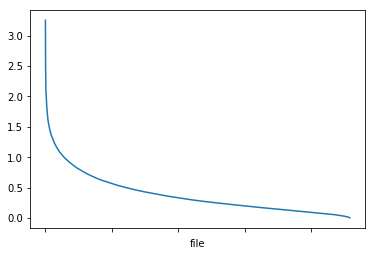

In [98]:
ret = info[info["label"]==1]["loss"]
ret.plot()

In [101]:
ret[:len(ret)//2].mean(), ret[len(ret)//2:].mean()

(0.6221079993564339, 0.15208605436380399)


0it [00:00, ?it/s]
28it [00:00, 272.27it/s]
50it [00:00, 268.36it/s]

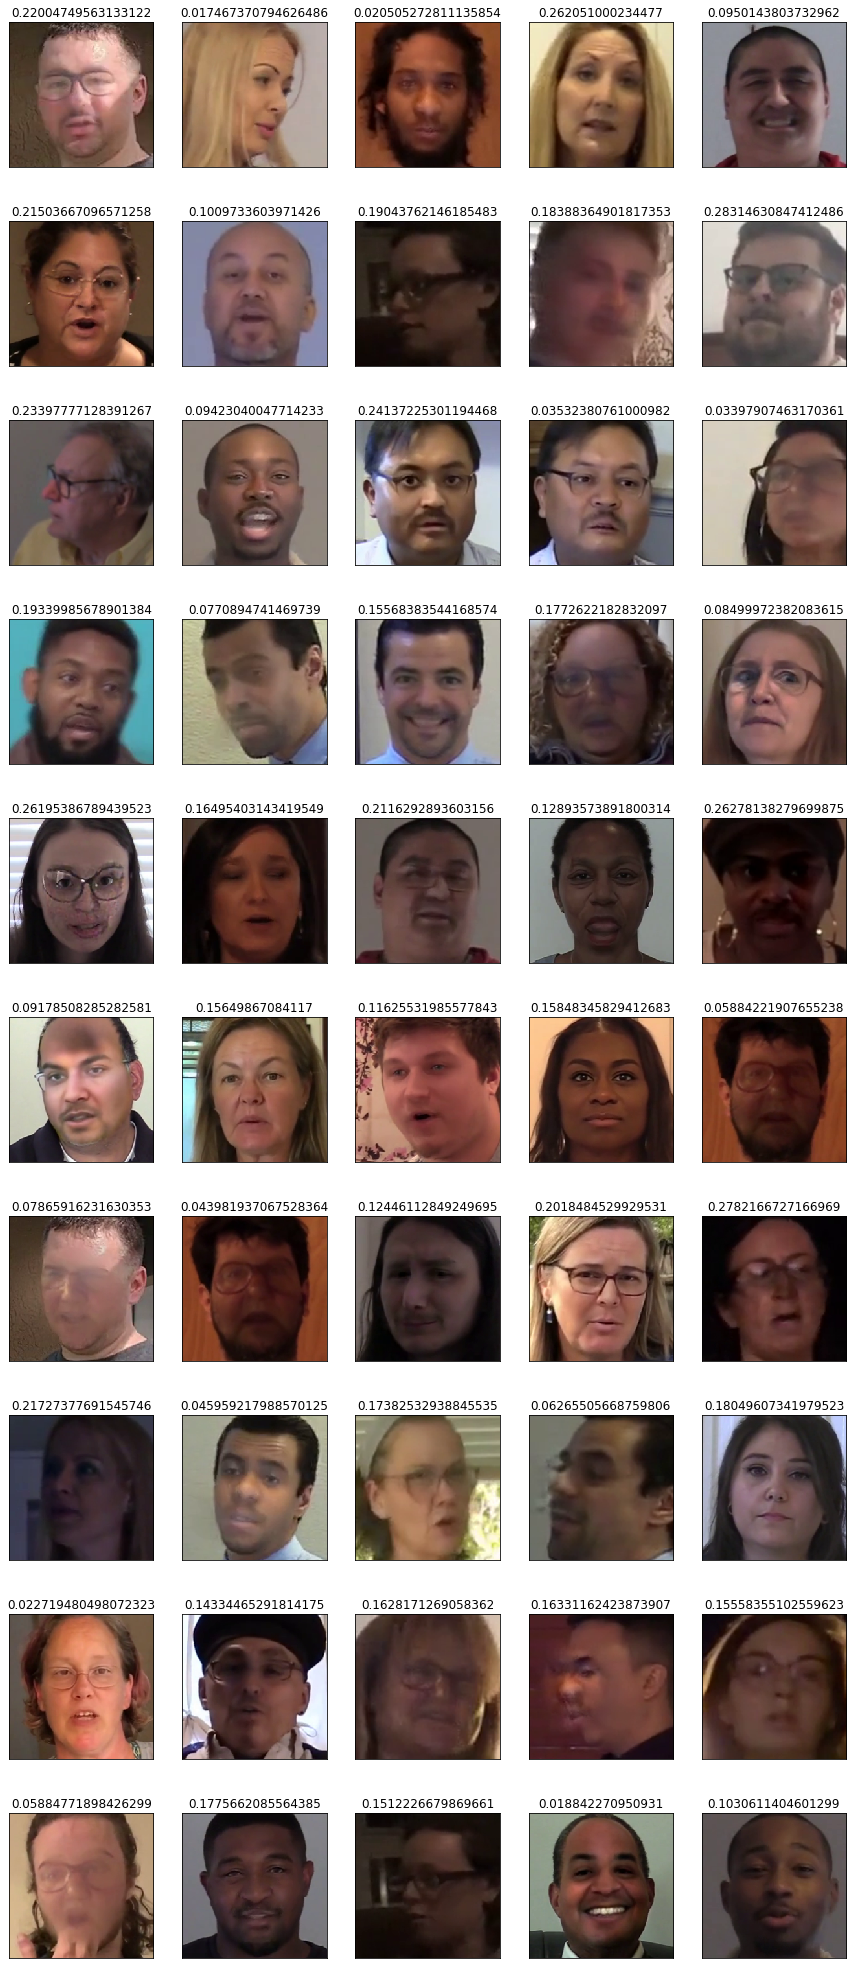

In [104]:
view_loss(info[info["label"]==1][len(ret)//2:].sample(50))

In [109]:
metadata.T.to_json(f'/data/deepfake/metadata/metadata_half_little_drops.json')

In [ ]:
metadata = pd.read_json('/data/deepfake/metadata/metadata_half_dropped.json').T
df = metadata[((metadata['split_kailu'] == 'validation') | (metadata['split_kailu'] == 'test'))]
df = pd.concat([df[df["label"] == "REAL"].sample(200), df[df["label"] == "FAKE"].sample(200)])